### Carga de librerias

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
#import mungo as msno

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import kds

In [2]:
df_cros = pd.read_csv("../data/raw/train.csv").set_index("id")
df_cros = df_cros.rename(columns={"Response":"Compraron"})

In [3]:
#Usar la etiqueta proporcionada en el conjunto de datos para convertir una columna discreta en una columna categórica
df_cros["Driving_License"] = df_cros["Driving_License"].replace({0:"No",1:"Yes"})
df_cros["Previously_Insured"] = df_cros["Previously_Insured"].replace({0:"No",1:"Yes"})
df_cros["Compraron"] = df_cros["Compraron"].replace({0:"No",1:"Yes"})

### Analisis de variables categoricas vs compraron (objetivo)

In [4]:
# Creando una función para visualización
def pie_bar_plot(df, col, hue):
    plt.figure(figsize=(10, 4))
    
    # Extraer recuentos de valores para la columna especificada
    col_counts = df[col].value_counts().sort_index()
    
    # Primera subtrama: gráfico circular
    plt.subplot(1, 2, 1) 
    ax1 = col_counts
    plt.title(f"Distribution by {col}", fontweight="black", size=10, pad=11)
    colors = sns.color_palette('Set2', len(ax1))
    plt.pie(ax1.values, labels=ax1.index, autopct="%.1f%%", pctdistance=0.75, startangle=90, 
            colors=colors, textprops={"size":14})
    center_circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)
    
    # Segunda subtrama: diagrama de barras
    plt.subplot(1, 2, 2)
    new_df = df[df[hue] == 'Yes']
    value_1 = col_counts
    value_2 = new_df[col].value_counts().sort_index()  # Ordenar los valores en el mismo orden.
    ax2 = np.round((value_2 / value_1) * 100, 1).values
    sns.barplot(x=value_2.index, y=value_2.values, palette='Set2')
    plt.title(f"Employee Opting for Insurance by {col}", fontweight="black", size=10, pad=11)
    for index, value in enumerate(value_2):
        plt.text(index, value, str(value) + " (" + str(float(ax2[index])) + "% )", ha="center", va="bottom", size=10)

    plt.tight_layout()
    plt.show()

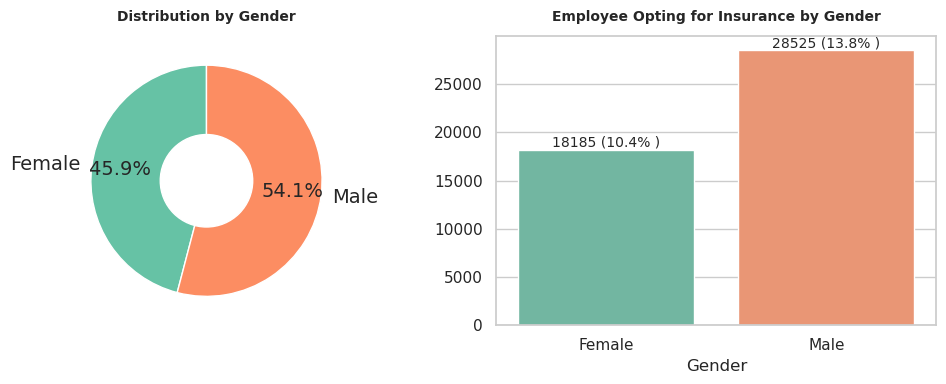

In [5]:
#Análisis del seguro de vehículos de los clientes por género
pie_bar_plot(df_cros, 'Gender', 'Compraron')